# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [28]:
import time
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

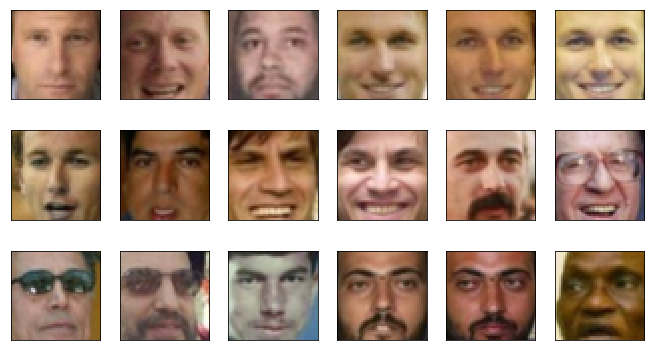

In [6]:
plot_gallery(X_train, image_h, image_w)

In [62]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [776]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self, in_size):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, dimZ),
            nn.BatchNorm1d(dimZ),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, in_size),
            nn.Sigmoid(),
        )
        self.apply(self.init_weights)
        
    def encode(self, x):
        return self.encoder.forward(x)
    
    def decode(self, z):
        return self.decoder.forward(z)
        
    @staticmethod
    def init_weights(module):
        if isinstance(module, nn.Linear):
            module.bias.data.fill_(0.0)
        
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [785]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder(6075).cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

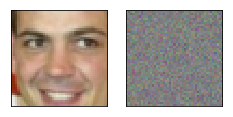

Epoch 0 took 0.770 sec, train loss: 0.012
Epoch 1 took 0.736 sec, train loss: 0.007
Epoch 2 took 0.737 sec, train loss: 0.006
Epoch 3 took 0.738 sec, train loss: 0.006
Epoch 4 took 0.736 sec, train loss: 0.005
Epoch 5 took 0.737 sec, train loss: 0.005
Epoch 6 took 0.736 sec, train loss: 0.005
Epoch 7 took 0.737 sec, train loss: 0.004
Epoch 8 took 0.736 sec, train loss: 0.004
Epoch 9 took 0.738 sec, train loss: 0.004


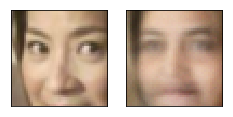

Epoch 10 took 0.776 sec, train loss: 0.004
Epoch 11 took 0.736 sec, train loss: 0.004
Epoch 12 took 0.735 sec, train loss: 0.004
Epoch 13 took 0.735 sec, train loss: 0.004
Epoch 14 took 0.735 sec, train loss: 0.004
Epoch 15 took 0.735 sec, train loss: 0.003
Epoch 16 took 0.736 sec, train loss: 0.003
Epoch 17 took 0.739 sec, train loss: 0.003
Epoch 18 took 0.735 sec, train loss: 0.003
Epoch 19 took 0.735 sec, train loss: 0.003


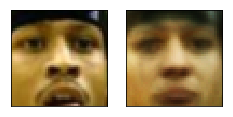

Epoch 20 took 0.763 sec, train loss: 0.003
Epoch 21 took 0.737 sec, train loss: 0.003
Epoch 22 took 0.737 sec, train loss: 0.003
Epoch 23 took 0.745 sec, train loss: 0.003
Epoch 24 took 0.737 sec, train loss: 0.003
Epoch 25 took 0.737 sec, train loss: 0.003
Epoch 26 took 0.736 sec, train loss: 0.003
Epoch 27 took 0.736 sec, train loss: 0.003
Epoch 28 took 0.734 sec, train loss: 0.003
Epoch 29 took 0.735 sec, train loss: 0.003


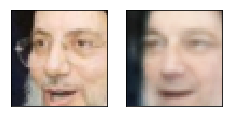

Epoch 30 took 0.763 sec, train loss: 0.003
Epoch 31 took 0.735 sec, train loss: 0.003
Epoch 32 took 0.736 sec, train loss: 0.003
Epoch 33 took 0.737 sec, train loss: 0.003
Epoch 34 took 0.735 sec, train loss: 0.003
Epoch 35 took 0.735 sec, train loss: 0.003
Epoch 36 took 0.736 sec, train loss: 0.003
Epoch 37 took 0.740 sec, train loss: 0.003
Epoch 38 took 0.736 sec, train loss: 0.003
Epoch 39 took 0.734 sec, train loss: 0.003


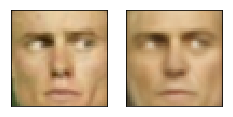

Epoch 40 took 0.763 sec, train loss: 0.003
Epoch 41 took 0.735 sec, train loss: 0.003
Epoch 42 took 0.735 sec, train loss: 0.003
Epoch 43 took 0.735 sec, train loss: 0.003
Epoch 44 took 0.735 sec, train loss: 0.003
Epoch 45 took 0.735 sec, train loss: 0.002
Epoch 46 took 0.736 sec, train loss: 0.003
Epoch 47 took 0.735 sec, train loss: 0.002
Epoch 48 took 0.735 sec, train loss: 0.002
Epoch 49 took 0.737 sec, train loss: 0.002


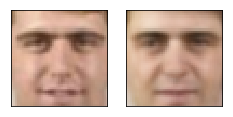

Epoch 50 took 0.766 sec, train loss: 0.002
Epoch 51 took 0.749 sec, train loss: 0.002
Epoch 52 took 0.739 sec, train loss: 0.002
Epoch 53 took 0.738 sec, train loss: 0.002
Epoch 54 took 0.738 sec, train loss: 0.002
Epoch 55 took 0.738 sec, train loss: 0.002
Epoch 56 took 0.736 sec, train loss: 0.002
Epoch 57 took 0.737 sec, train loss: 0.002
Epoch 58 took 0.739 sec, train loss: 0.002
Epoch 59 took 0.737 sec, train loss: 0.002


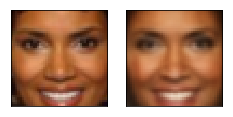

Epoch 60 took 0.768 sec, train loss: 0.002
Epoch 61 took 0.736 sec, train loss: 0.002
Epoch 62 took 0.737 sec, train loss: 0.002
Epoch 63 took 0.737 sec, train loss: 0.002
Epoch 64 took 0.735 sec, train loss: 0.002
Epoch 65 took 0.744 sec, train loss: 0.002
Epoch 66 took 0.736 sec, train loss: 0.002
Epoch 67 took 0.737 sec, train loss: 0.002
Epoch 68 took 0.737 sec, train loss: 0.002
Epoch 69 took 0.737 sec, train loss: 0.002


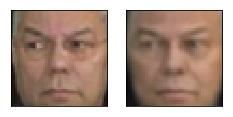

Epoch 70 took 0.764 sec, train loss: 0.002
Epoch 71 took 0.736 sec, train loss: 0.002
Epoch 72 took 0.751 sec, train loss: 0.002
Epoch 73 took 0.736 sec, train loss: 0.002
Epoch 74 took 0.735 sec, train loss: 0.002
Epoch 75 took 0.736 sec, train loss: 0.002
Epoch 76 took 0.737 sec, train loss: 0.002
Epoch 77 took 0.735 sec, train loss: 0.002
Epoch 78 took 0.736 sec, train loss: 0.002
Epoch 79 took 0.744 sec, train loss: 0.002


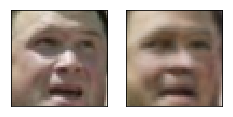

Epoch 80 took 0.763 sec, train loss: 0.002
Epoch 81 took 0.735 sec, train loss: 0.002
Epoch 82 took 0.736 sec, train loss: 0.002
Epoch 83 took 0.736 sec, train loss: 0.002
Epoch 84 took 0.736 sec, train loss: 0.002
Epoch 85 took 0.735 sec, train loss: 0.002
Epoch 86 took 0.736 sec, train loss: 0.002
Epoch 87 took 0.736 sec, train loss: 0.002
Epoch 88 took 0.736 sec, train loss: 0.002
Epoch 89 took 0.737 sec, train loss: 0.002


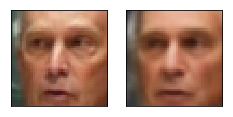

Epoch 90 took 0.765 sec, train loss: 0.002
Epoch 91 took 0.742 sec, train loss: 0.002
Epoch 92 took 0.739 sec, train loss: 0.002
Epoch 93 took 0.742 sec, train loss: 0.002
Epoch 94 took 0.736 sec, train loss: 0.002
Epoch 95 took 0.736 sec, train loss: 0.002
Epoch 96 took 0.734 sec, train loss: 0.002
Epoch 97 took 0.735 sec, train loss: 0.002
Epoch 98 took 0.735 sec, train loss: 0.002
Epoch 99 took 0.740 sec, train loss: 0.002


In [786]:
num_epochs = 100

for epoch in range(num_epochs):
    start_time = time.time()
    autoencoder.train(True)
    train_loss = 0.0
    for idx, (X_batch, _) in enumerate(train_loader):
        X_batch = torch.autograd.Variable(X_batch).cuda()
        reconstruction, code = autoencoder(X_batch)
        loss = criterion(reconstruction, X_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.data.cpu().numpy()[0]
        if idx == 0 and epoch % 10 == 0:
            plot_gallery(torch.stack((X_batch[0], reconstruction[0]), 0).data.cpu().numpy(), image_h, image_w, n_row=1, n_col=2)
            plt.show()
    train_loss /= len(train_loader)

    print("Epoch {} took {:.3f} sec, train loss: {:.3f}"
          .format(epoch, time.time() - start_time, train_loss))

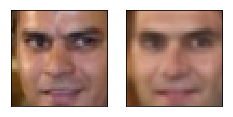

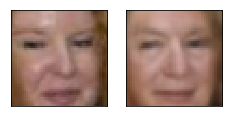

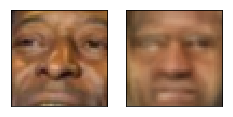

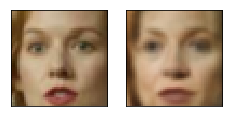

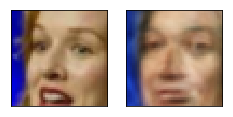

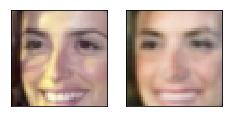

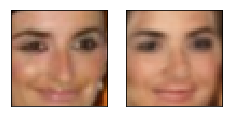

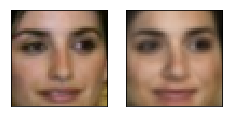

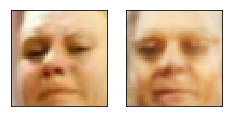

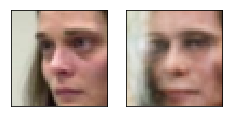

In [791]:
# Examine the reconstructions
autoencoder.train(False)
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

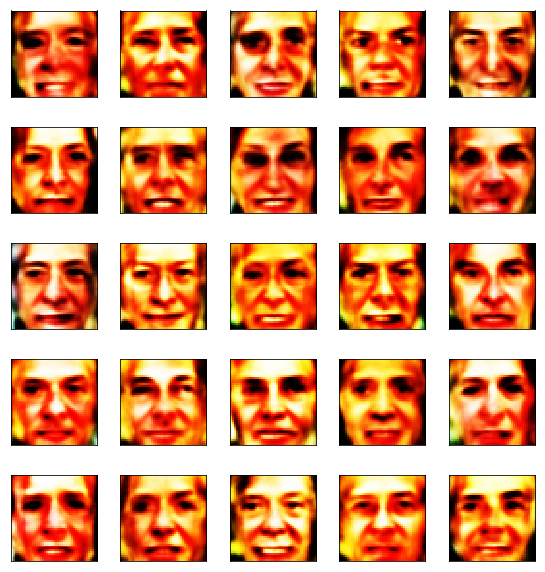

In [792]:
z = np.random.randn(25, dimZ).astype(np.float32)
output = autoencoder.decoder(Variable(torch.from_numpy(z).cuda()))
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [793]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self, in_size):
        super(VAE, self).__init__()
        self.in_size = in_size
        self.encoder = nn.Sequential(
            nn.Linear(in_size, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            nn.Linear(3072, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.Linear(1536, 2 * dimZ),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.Linear(1536, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU(),
            nn.Linear(3072, 2 * in_size)
        )
        self.sigmoid = nn.Sigmoid()
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def encode_distr(self, x):
        encoder_output = self.encoder.forward(x)
        latent_mu = encoder_output[:, :dimZ]
        latent_logsigma = encoder_output[:, dimZ:]
        return latent_mu, latent_logsigma
        
    def encode(self, x):
        return self.encode_distr(x)[0]
    
    def decode_distr(self, z):
        decoder_output = self.decoder.forward(z)
        reconstruction_mu = self.sigmoid(decoder_output[:, :self.in_size])
        reconstruction_logsigma = decoder_output[:, self.in_size:]
        return reconstruction_mu, reconstruction_logsigma
    
    def decode(self, z):
        return self.decode_distr(z)[0]

    def forward(self, x):
        latent_mu, latent_logsigma = self.encode_distr(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode_distr(z)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=$$

$$= C + \sum_{i=1}^{dimX} \log(\sigma_i) - \frac{1}{2 \sigma_i^2} (\mu_i - x_i)^2$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$? $\sigma$ cannot be negative.

In [794]:
def KL_divergence(mu, logsigma):
    dimZ = mu.shape[1]
    return -0.5 * (dimZ + 2 * logsigma.sum(1) - (mu ** 2).sum(1) - (2 * logsigma).exp().sum(1))

def log_likelihood(x, mu, logsigma):
    return -logsigma.sum(1) - ((mu - x) ** 2 / (2 * (2 * logsigma).exp())).sum(1)

def loss_vae(idx, x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    first_term = log_likelihood(x, mu_gen, logsigma_gen)
    second_term = KL_divergence(mu_z, logsigma_z)
    return -(first_term - second_term).mean()

And train the model:

In [795]:
vae = VAE(6075).cuda()
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

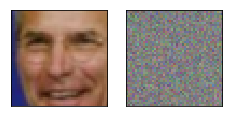

Epoch 0 took 3.474 sec, train loss: -8207.689
Epoch 1 took 3.444 sec, train loss: -11299.501
Epoch 2 took 3.449 sec, train loss: -12006.424
Epoch 3 took 3.445 sec, train loss: -12448.921
Epoch 4 took 3.445 sec, train loss: -12753.261
Epoch 5 took 3.447 sec, train loss: -12948.333
Epoch 6 took 3.445 sec, train loss: -13144.292
Epoch 7 took 3.446 sec, train loss: -13270.336
Epoch 8 took 3.449 sec, train loss: -13441.859
Epoch 9 took 3.445 sec, train loss: -13588.193


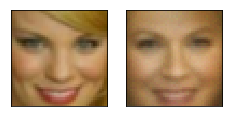

Epoch 10 took 3.475 sec, train loss: -13671.136
Epoch 11 took 3.448 sec, train loss: -13679.123
Epoch 12 took 3.447 sec, train loss: -13809.341
Epoch 13 took 3.445 sec, train loss: -13903.459
Epoch 14 took 3.449 sec, train loss: -14000.016
Epoch 15 took 3.450 sec, train loss: -14023.370
Epoch 16 took 3.444 sec, train loss: -14181.148
Epoch 17 took 3.449 sec, train loss: -14232.281
Epoch 18 took 3.446 sec, train loss: -14268.661
Epoch 19 took 3.448 sec, train loss: -14341.609


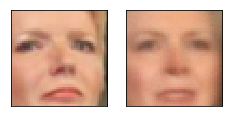

Epoch 20 took 3.472 sec, train loss: -14405.566
Epoch 21 took 3.446 sec, train loss: -14444.225
Epoch 22 took 3.448 sec, train loss: -14478.756
Epoch 23 took 3.447 sec, train loss: -14531.233
Epoch 24 took 3.444 sec, train loss: -14557.380
Epoch 25 took 3.449 sec, train loss: -14600.111
Epoch 26 took 3.448 sec, train loss: -14666.858
Epoch 27 took 3.446 sec, train loss: -14755.285
Epoch 28 took 3.451 sec, train loss: -14783.829
Epoch 29 took 3.452 sec, train loss: -14795.862


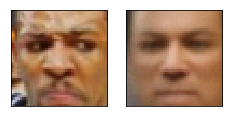

Epoch 30 took 3.475 sec, train loss: -14827.019
Epoch 31 took 3.446 sec, train loss: -14944.086
Epoch 32 took 3.452 sec, train loss: -14927.292
Epoch 33 took 3.446 sec, train loss: -14910.969
Epoch 34 took 3.444 sec, train loss: -15008.351
Epoch 35 took 3.449 sec, train loss: -14993.358
Epoch 36 took 3.446 sec, train loss: -15044.324
Epoch 37 took 3.446 sec, train loss: -15108.162
Epoch 38 took 3.448 sec, train loss: -15093.986
Epoch 39 took 3.451 sec, train loss: -15157.251


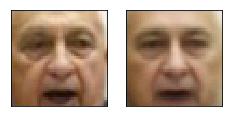

Epoch 40 took 3.474 sec, train loss: -15117.716
Epoch 41 took 3.447 sec, train loss: -15249.124
Epoch 42 took 3.446 sec, train loss: -15325.058
Epoch 43 took 3.445 sec, train loss: -15318.811
Epoch 44 took 3.448 sec, train loss: -15315.741
Epoch 45 took 3.449 sec, train loss: -15367.663
Epoch 46 took 3.447 sec, train loss: -15251.404
Epoch 47 took 3.452 sec, train loss: -15381.694
Epoch 48 took 3.447 sec, train loss: -15359.752
Epoch 49 took 3.446 sec, train loss: -15434.544


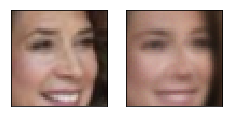

Epoch 50 took 3.479 sec, train loss: -15477.140
Epoch 51 took 3.446 sec, train loss: -15464.136
Epoch 52 took 3.444 sec, train loss: -15528.916
Epoch 53 took 3.446 sec, train loss: -15576.620
Epoch 54 took 3.447 sec, train loss: -15586.232
Epoch 55 took 3.445 sec, train loss: -15583.139
Epoch 56 took 3.449 sec, train loss: -15663.112
Epoch 57 took 3.447 sec, train loss: -15623.603
Epoch 58 took 3.445 sec, train loss: -15582.703
Epoch 59 took 3.447 sec, train loss: -15639.532


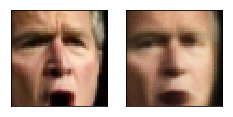

Epoch 60 took 3.474 sec, train loss: -15693.019
Epoch 61 took 3.446 sec, train loss: -15757.258
Epoch 62 took 3.450 sec, train loss: -15663.908
Epoch 63 took 3.449 sec, train loss: -15762.827
Epoch 64 took 3.447 sec, train loss: -15785.874
Epoch 65 took 3.451 sec, train loss: -15829.190
Epoch 66 took 3.450 sec, train loss: -15768.412
Epoch 67 took 3.452 sec, train loss: -15782.825
Epoch 68 took 3.449 sec, train loss: -15792.574
Epoch 69 took 3.446 sec, train loss: -15818.181


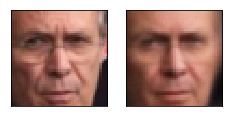

Epoch 70 took 3.476 sec, train loss: -15785.853
Epoch 71 took 3.448 sec, train loss: -15885.705
Epoch 72 took 3.448 sec, train loss: -15922.177
Epoch 73 took 3.445 sec, train loss: -15887.765
Epoch 74 took 3.453 sec, train loss: -16001.160
Epoch 75 took 3.447 sec, train loss: -16005.567
Epoch 76 took 3.446 sec, train loss: -15913.586
Epoch 77 took 3.448 sec, train loss: -15908.849
Epoch 78 took 3.447 sec, train loss: -16011.084
Epoch 79 took 3.448 sec, train loss: -16002.876


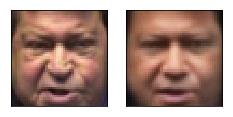

Epoch 80 took 3.478 sec, train loss: -16056.827
Epoch 81 took 3.447 sec, train loss: -16039.341
Epoch 82 took 3.449 sec, train loss: -16071.657
Epoch 83 took 3.451 sec, train loss: -16127.744
Epoch 84 took 3.453 sec, train loss: -16116.354
Epoch 85 took 3.448 sec, train loss: -16077.292
Epoch 86 took 3.458 sec, train loss: -16112.755
Epoch 87 took 3.448 sec, train loss: -16160.901
Epoch 88 took 3.447 sec, train loss: -16248.250
Epoch 89 took 3.450 sec, train loss: -16196.400


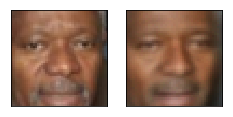

Epoch 90 took 3.479 sec, train loss: -16219.045
Epoch 91 took 3.449 sec, train loss: -16271.747
Epoch 92 took 3.451 sec, train loss: -16140.223
Epoch 93 took 3.447 sec, train loss: -16170.447
Epoch 94 took 3.446 sec, train loss: -16193.651
Epoch 95 took 3.449 sec, train loss: -16189.909
Epoch 96 took 3.445 sec, train loss: -16228.042
Epoch 97 took 3.448 sec, train loss: -16320.224
Epoch 98 took 3.448 sec, train loss: -16344.452
Epoch 99 took 3.446 sec, train loss: -16340.364


In [796]:
num_epochs = 100

for epoch in range(num_epochs):
    start_time = time.time()
    vae.train(True)
    train_loss = 0.0
    for idx, (X_batch, _) in enumerate(train_loader):
        X_batch = torch.autograd.Variable(X_batch).cuda()
        mu_gen, logsigma_gen, mu_z, logsigma_z = vae(X_batch)
        loss = loss_vae(idx, X_batch, mu_gen, logsigma_gen, mu_z, logsigma_z)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.data.cpu().numpy()[0]
        if idx == 0 and epoch % 10 == 0:
            plot_gallery(torch.stack((X_batch[0], mu_gen[0]), 0).data.cpu().numpy(), image_h, image_w, n_row=1, n_col=2)
            plt.show()
    train_loss /= len(train_loader)

    print("Epoch {} took {:.3f} sec, train loss: {:.3f}"
          .format(epoch, time.time() - start_time, train_loss))

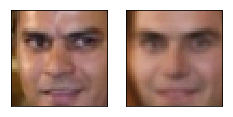

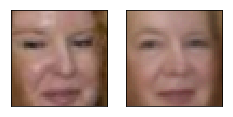

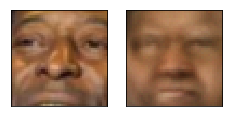

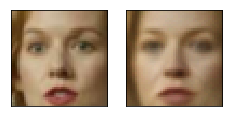

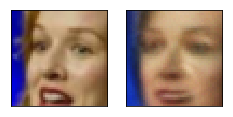

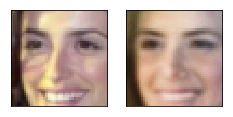

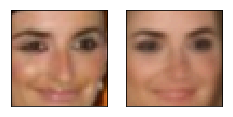

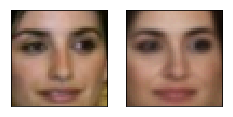

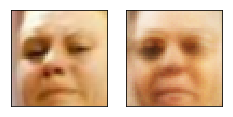

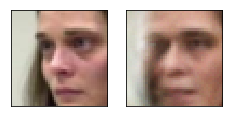

In [797]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

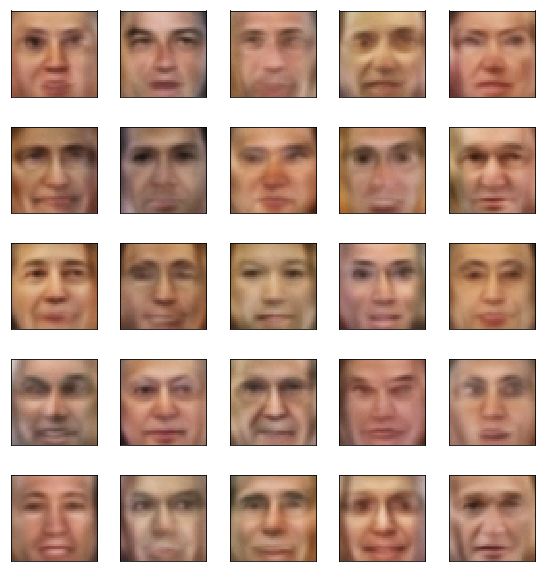

In [798]:
# decoder_mu(z), z ~ N(0, 1)
z = np.random.randn(25, dimZ).astype(np.float32) * 0.5
decoder_mu = vae.decode(Variable(torch.from_numpy(z).cuda()))
plot_gallery(decoder_mu.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

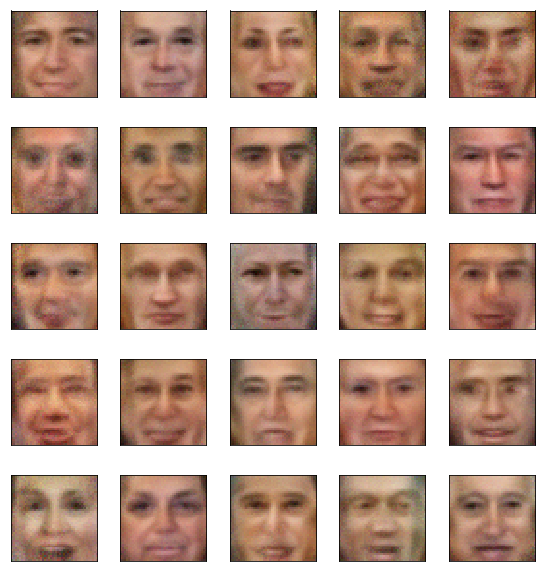

In [799]:
# Sample from N(decoder_mu(z), decoder_sigma(z)), z ~ N(0, 0.5)
z = np.random.randn(25, dimZ).astype(np.float32) * 0.5
decoder_mu, decoder_logsigma = vae.decode_distr(Variable(torch.from_numpy(z).cuda()))
img = decoder_mu.data.new(decoder_mu.shape).normal_() * decoder_logsigma.data.exp() + decoder_mu.data
plot_gallery(img.clamp(0.0, 1.0).cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [800]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [801]:
def get_feature_diff_vec(feature_name, model, num_examples=50):
    feature_ind = np.argsort(attrs[:10000][feature_name])
    no_feature = Variable(torch.FloatTensor(X_train[feature_ind[:num_examples]]), requires_grad=False, volatile=True).cuda()
    no_feature_latent = model.encode(no_feature).mean(0)

    feature = Variable(torch.FloatTensor(X_train[feature_ind[-num_examples:]]), requires_grad=False, volatile=True).cuda()
    feature_latent = model.encode(feature)[0].mean(0)
    return feature_latent - no_feature_latent

In [802]:
smile_ind = np.argsort(attrs[:10000]["Smiling"])

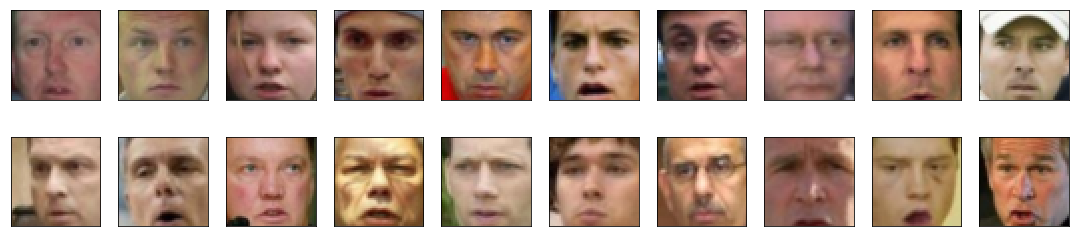

In [803]:
plot_gallery(X_train[smile_ind[:20]], image_h, image_w, n_row=2, n_col=10)

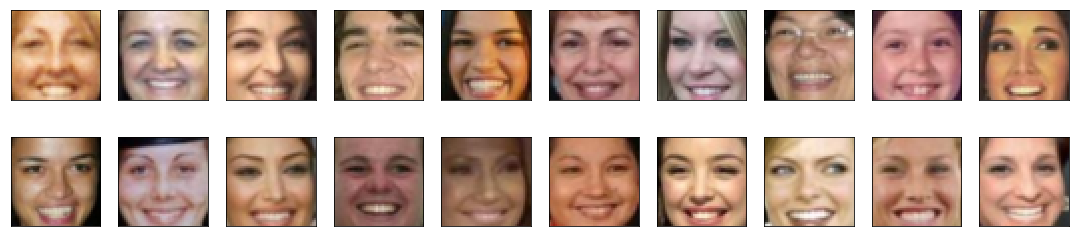

In [804]:
plot_gallery(X_train[smile_ind[-20:]], image_h, image_w, n_row=2, n_col=10)

In [805]:
def apply_linspace(idx, model, feature_diff, coefs=[-1.5, -0.75, 0.0, 0.75, 1.5]):
    idx = 935
    face = Variable(torch.FloatTensor(X_train[idx:idx+1])).cuda()

    model.eval()
    z = model.encode(face)
    faces = []
    for coef in coefs:
        if coef != 0.0:
            faces.append(model.decode(z + coef * feature_diff))
        else:
            faces.append(face)

    plot_gallery(torch.cat((faces), 0).data.cpu().numpy(), image_h, image_w, n_col=len(coefs), n_row=1)

In [806]:
def sample_with_diff(model, diff, alpha=0.5, beta=0.5):
    # decoder_mu(z), z ~ N(0, 1.5)
    z = alpha * np.random.randn(25, dimZ).astype(np.float32) + beta * diff.data.cpu().numpy()
    decoder_mu = model.decode(Variable(torch.from_numpy(z).cuda()))
    plot_gallery(decoder_mu.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

## VAE

Schwarzenegger:


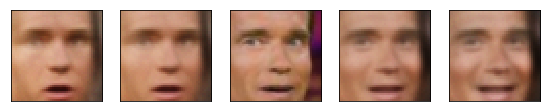

Sampling:


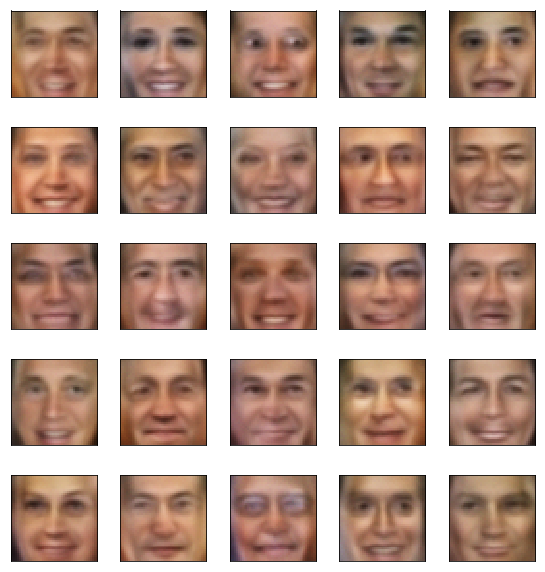

In [807]:
smiling_diff = get_feature_diff_vec("Smiling", vae)
print("Schwarzenegger:")
apply_linspace(935, vae, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(vae, smiling_diff)

Schwarzenegger:


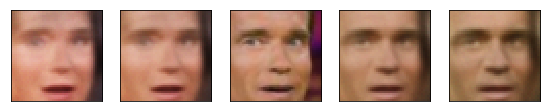

Sampling:


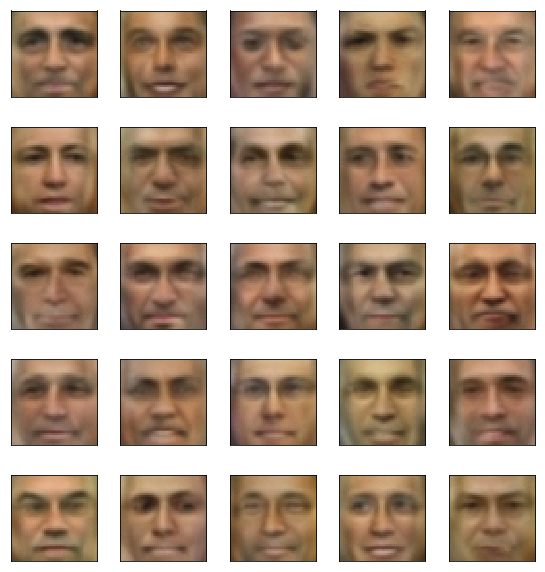

In [808]:
smiling_diff = get_feature_diff_vec("Black", vae)
print("Schwarzenegger:")
apply_linspace(935, vae, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(vae, smiling_diff, beta=1.0)

Schwarzenegger:


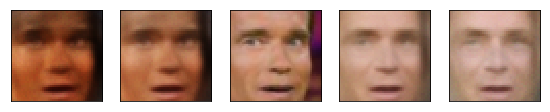

Sampling:


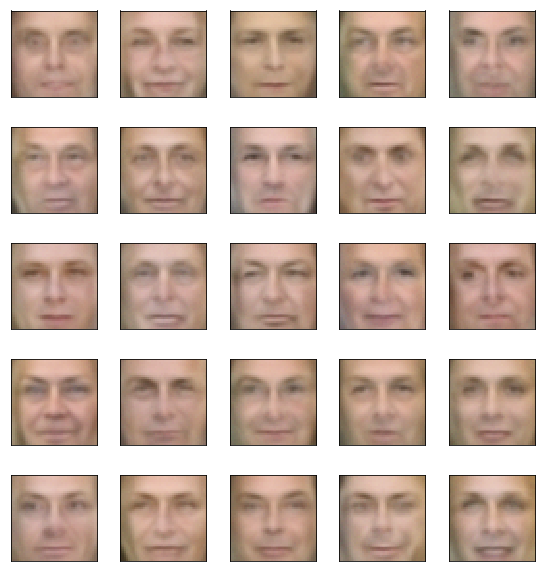

In [809]:
smiling_diff = get_feature_diff_vec("Pale Skin", vae)
print("Schwarzenegger:")
apply_linspace(935, vae, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(vae, smiling_diff, beta=1)

## AE

For some reason sampling from AE works bad, but still Arnold seems quite happy

Schwarzenegger:


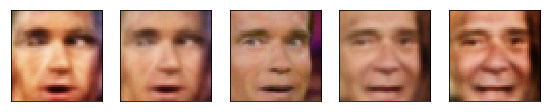

Sampling:


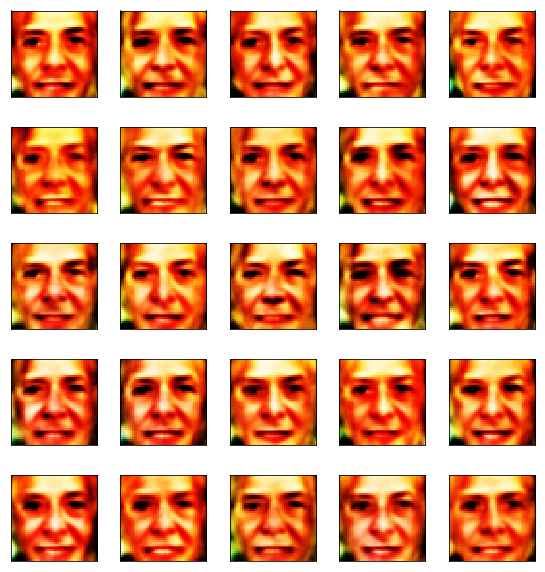

In [810]:
smiling_diff = get_feature_diff_vec("Smiling", autoencoder)
print("Schwarzenegger:")
apply_linspace(935, autoencoder, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(autoencoder, smiling_diff)

Schwarzenegger:


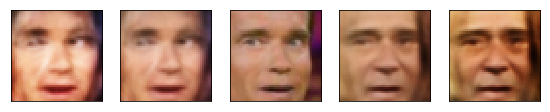

Sampling:


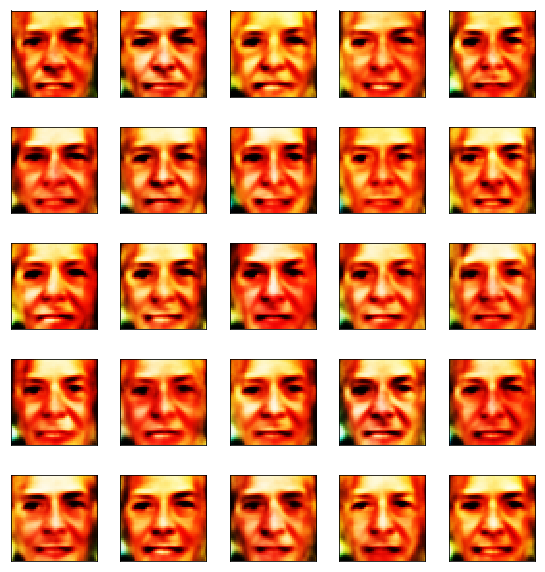

In [811]:
smiling_diff = get_feature_diff_vec("Black", autoencoder)
print("Schwarzenegger:")
apply_linspace(935, autoencoder, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(autoencoder, smiling_diff)

Schwarzenegger:


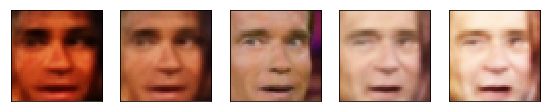

Sampling:


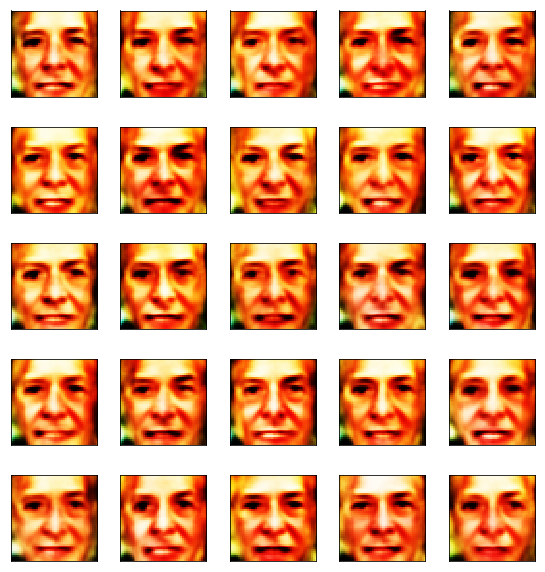

In [812]:
smiling_diff = get_feature_diff_vec("Pale Skin", autoencoder)
print("Schwarzenegger:")
apply_linspace(935, autoencoder, smiling_diff)
plt.show()
print("Sampling:")
sample_with_diff(autoencoder, smiling_diff)

<img src="linear.png" alt="linear">